# Songs Exploratory Data Analysis

In [1]:
# Importing necessary modules
from pyspark.sql import SparkSession
import pyspark.sql.functions as fun
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import LogisticRegression
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns 


In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPAK_DRIVER_PYTHON'] = sys.executable

In [3]:
# Creating a spark session
spark = SparkSession.builder.master("local[1]").appName("Spotify_Recommendations").getOrCreate()

23/07/18 22:27:01 WARN Utils: Your hostname, Raveeshs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.4 instead (on interface en0)
23/07/18 22:27:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/18 22:27:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
# Reading the dataset using spark. Setting inferSchema=True so that spark can
# intelligently read the CSV file and set the datatypes of all columns
df = spark.read.csv("songs_data.csv", header=True, inferSchema=True)

In [6]:
# Showing first 5 row of the read data
df.show(5)

+---+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|_c0|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|liked/disliked|
+---+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|  1|       0.445|  0.83| 2.0|  -7.328| 1.0|     0.0454|     0.00273|           0.001|   0.131|  0.693|125.432|             1|
|  2|       0.581| 0.424| 8.0|  -6.616| 1.0|     0.0269|       0.723|             0.0|   0.101|  0.352| 98.936|             1|
|  3|       0.637| 0.825|11.0|  -6.612| 1.0|     0.0815|       0.352|             0.0|   0.389|  0.835| 92.029|             1|
|  4|       0.759|  0.54| 9.0|  -6.039| 0.0|     0.0287|       0.037|             0.0|  0.0945|   0.75|116.947|             1|
|  5|         0.5| 0.337|10.0| -15.412| 1.0|     0.0381|      0.0725|           0.772|  0.0962| 0.0393|144.116|

23/07/18 22:27:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, liked/disliked
 Schema: _c0, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, liked/disliked
Expected: _c0 but found: 
CSV file: file:///Users/raveeshyadav/GitHub/Spotify-recommendations/songs_data.csv


In [7]:
# Removing column _c0 as it is vestigial
df = df.drop(fun.col('_c0'))
df.show(5)

+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|liked/disliked|
+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|       0.445|  0.83| 2.0|  -7.328| 1.0|     0.0454|     0.00273|           0.001|   0.131|  0.693|125.432|             1|
|       0.581| 0.424| 8.0|  -6.616| 1.0|     0.0269|       0.723|             0.0|   0.101|  0.352| 98.936|             1|
|       0.637| 0.825|11.0|  -6.612| 1.0|     0.0815|       0.352|             0.0|   0.389|  0.835| 92.029|             1|
|       0.759|  0.54| 9.0|  -6.039| 0.0|     0.0287|       0.037|             0.0|  0.0945|   0.75|116.947|             1|
|         0.5| 0.337|10.0| -15.412| 1.0|     0.0381|      0.0725|           0.772|  0.0962| 0.0393|144.116|             1|
+------------+--

In [8]:
# Printing the schema for our data
df.printSchema()

root
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- liked/disliked: integer (nullable = true)



In [9]:
# Shape of the dataset
print('Shape of the dataset: ', (df.count(), len(df.columns)))

Shape of the dataset:  (184, 12)


In [10]:
# Checking whether the datset contains of any null values or not
df.agg(*[fun.count(fun.when(fun.isnull(column),column)).alias(column)for column in df.columns]).show()

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|liked/disliked|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|           2|     2|  2|       2|   2|          2|           2|               2|       2|      2|    2|             0|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+



In [11]:
# We can see that there are null values in our datset. Hence, we will remove them
# and re-verify for the null values 
df = df.na.drop()   # drop null values
df.agg(*[fun.count(fun.when(fun.isnull(column),column)).alias(column)for column in df.columns]).show()

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|liked/disliked|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|             0|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+



In [12]:
# Sumarizing the data in order to get a glimpse of the values and content of data 
df.describe().show()

23/07/18 22:27:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+
|summary|       danceability|            energy|               key|          loudness|              mode|        speechiness|       acousticness|   instrumentalness|          liveness|            valence|             tempo|    liked/disliked|
+-------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+
|  count|                182|               182|               182|               182|               182|                182|                182|                182|               182|                182|               182|               182|
|   mean| 0.6153186813186812

In [13]:
# Converting out datset into a pandas dataframe so that we can plot to get visual insights
data = df.toPandas()

In [14]:
# Printing first 5 elements of our pandas dataframe
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,liked/disliked
0,0.445,0.830,2.0,-7.328,1.0,0.0454,0.00273,0.001,0.1310,0.6930,125.432,1
1,0.581,0.424,8.0,-6.616,1.0,0.0269,0.72300,0.000,0.1010,0.3520,98.936,1
2,0.637,0.825,11.0,-6.612,1.0,0.0815,0.35200,0.000,0.3890,0.8350,92.029,1
3,0.759,0.540,9.0,-6.039,0.0,0.0287,0.03700,0.000,0.0945,0.7500,116.947,1
4,0.500,0.337,10.0,-15.412,1.0,0.0381,0.07250,0.772,0.0962,0.0393,144.116,1


<AxesSubplot:>

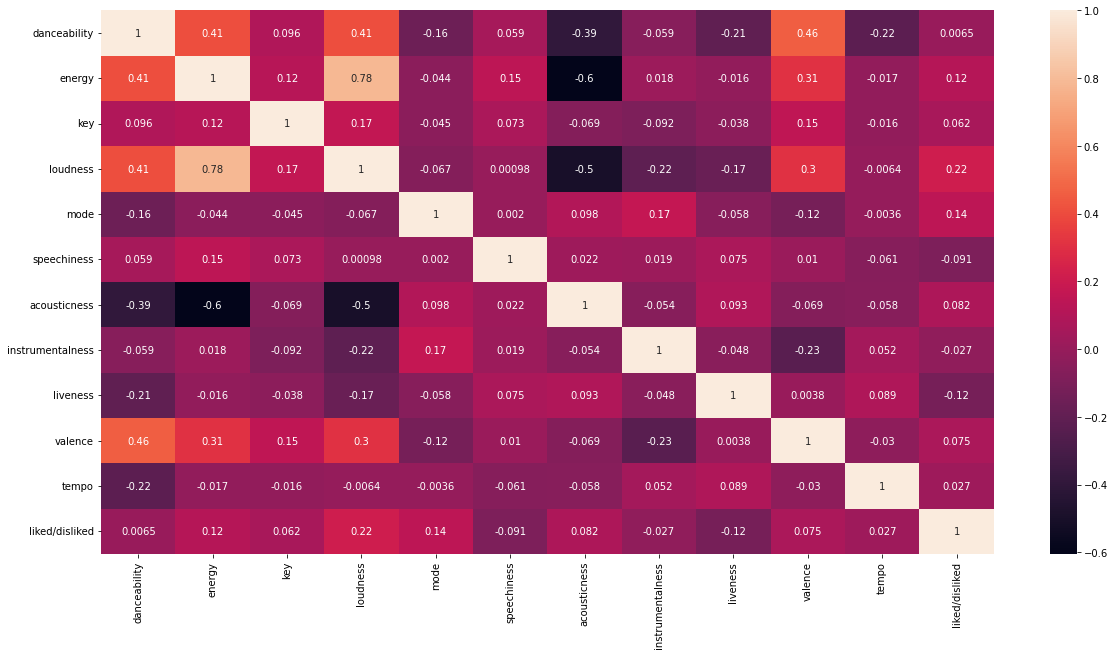

In [15]:
# Plotting a seaborn heatmap of our data. The hatmap will show relation between all the features

plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot = True)

<AxesSubplot:xlabel='loudness', ylabel='energy'>

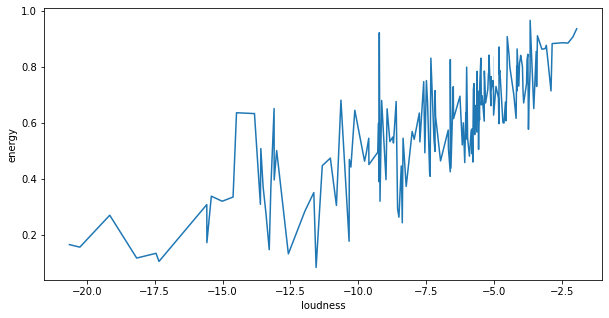

In [25]:
# Printing a visualisation between loudness and enrgy as the heatmap shows a 
# strong correlation between both of them

plt.figure(figsize=(10,5))
sns.lineplot(x=data['loudness'], y=data['energy'])

The above graph is clearly depicting tthat increase in loudness leads to an increase in energy

<AxesSubplot:xlabel='liked/disliked', ylabel='count'>

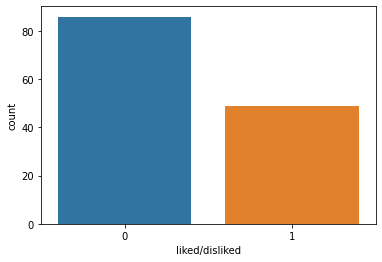

In [41]:
# Printing a count plot top see how much data is present for each liked as well as disliked song
sns.countplot(x='liked/disliked',data=data)

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1732384288.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['danceability'])


<AxesSubplot:xlabel='danceability', ylabel='Density'>

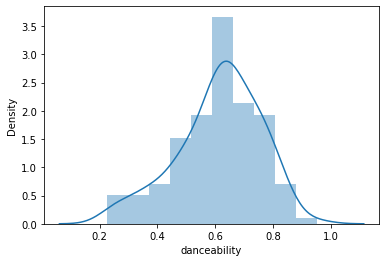

In [42]:
# Plotting user data's danceability trends
sns.distplot(data['danceability'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1084219847.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['energy'])


<AxesSubplot:xlabel='energy', ylabel='Density'>

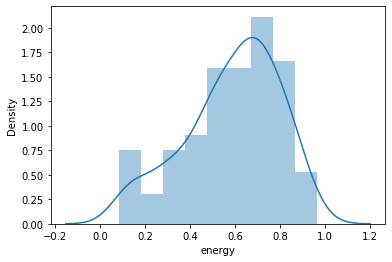

In [43]:
# Plotting user data's energy trends
sns.distplot(data['energy'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1246644979.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['key'])


<AxesSubplot:xlabel='key', ylabel='Density'>

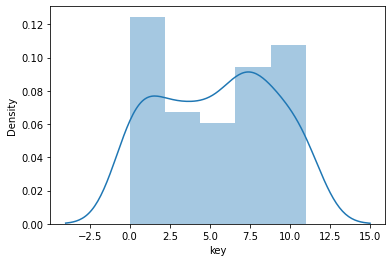

In [44]:
# Plotting user data's key trends
sns.distplot(data['key'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1778381608.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['loudness'])


<AxesSubplot:xlabel='loudness', ylabel='Density'>

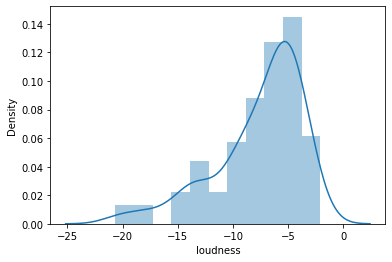

In [45]:
# Plotting user data's key trends
sns.distplot(data['loudness'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1059728595.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['mode'])


<AxesSubplot:xlabel='mode', ylabel='Density'>

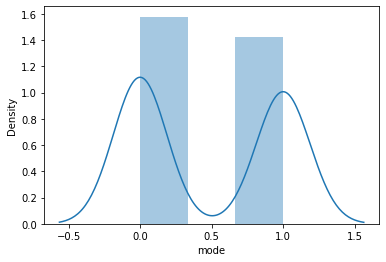

In [46]:
# Plotting user data's mode trends
sns.distplot(data['mode'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/773829482.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['speechiness'])


<AxesSubplot:xlabel='speechiness', ylabel='Density'>

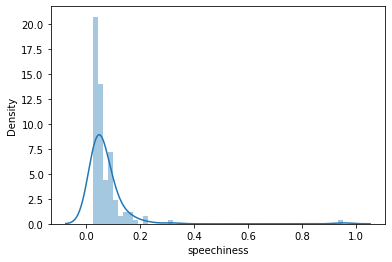

In [47]:
# Plotting user data's speachiness trends
sns.distplot(data['speechiness'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1984739871.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['acousticness'])


<AxesSubplot:xlabel='acousticness', ylabel='Density'>

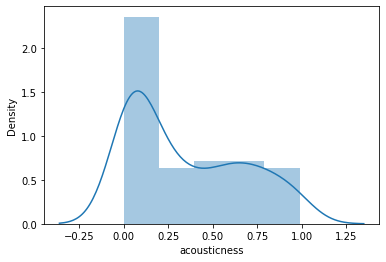

In [48]:
# Plotting user data's acousticness trends
sns.distplot(data['acousticness'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/297831868.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['instrumentalness'])


<AxesSubplot:xlabel='instrumentalness', ylabel='Density'>

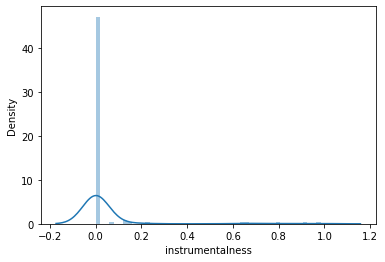

In [49]:
# Plotting user data's instrumentalness trends
sns.distplot(data['instrumentalness'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/437609218.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['valence'])


<AxesSubplot:xlabel='valence', ylabel='Density'>

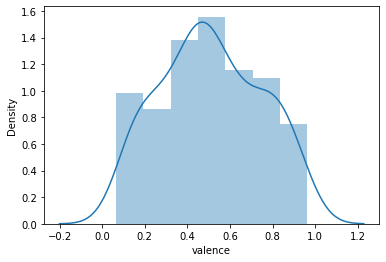

In [50]:
# Plotting user data's valence trends
sns.distplot(data['valence'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/3810897301.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['tempo'])


<AxesSubplot:xlabel='tempo', ylabel='Density'>

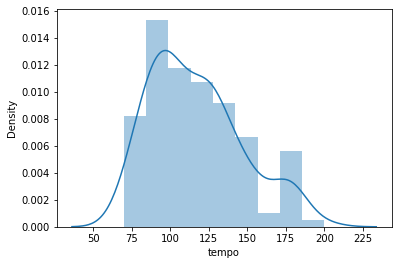

In [51]:
# Plotting user data's tempo trends
sns.distplot(data['tempo'])